## Collaborative Review Task M4


In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

#Share specific information
r = 0.1
S0 = 120
sigma = 0.25

#Put option specific information
K = 100
T = 2
k_log = np.log(K)

In [13]:
#Code for analytical solution for vanilla European Call Option
d_1_stock = (np.log(S0/K)+(r+sigma**2/2)*(T))/(sigma*np.sqrt(T))
d_2_stock = d_1_stock - sigma*np.sqrt(T)

analytic_call_price = S0*norm.cdf(d_1_stock) - K * np.exp(-r * (T))*norm.cdf(d_2_stock)

In [10]:
#The equation expressing put-call parity is: C + PV(k) = P + S

# where:
#C = price of the European call option
# PV(k) = the present value of the strike price (k), discounted from the value on the expiration date at the risk-free rate
# P = price of the European put
# S = spot price or the current market value of the underlying asset

In [12]:
#Given Stock spot price, call price, strike price, risk free rate and time period, option put price 
#can be easily evaluated using put-call parity equation.  

analytic_put_price = analytic_call_price +  K * np.exp(-r * (T)) -S0
print("analytic_put_price : ", analytic_put_price)

analytic_put_price :  2.469386750885704


In [4]:
# Characteristic functions
def c_M1(t):
    return np.exp(1j*t*(np.log(S0)+(r-sigma**2/2)*T) - (sigma**2)*T*(t**2)/2)

def c_M2(t):
    return np.exp(1j*t*sigma**2*T)*c_M1(t)

In [14]:
#Choosing t_max and N
t_max = 40
N = 200

#Calculating delta and constructing t_n
delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N-1/2)* delta_t

#Approximate integral estimates
first_integral = sum((((np.exp(-1j*t_n*k_log)*c_M2(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*c_M1(t_n)).imag)/t_n)*delta_t)

fourier_call_val = np.exp(-r*T)*K*(1/2 - second_integral/np.pi) - S0 * (1/2 - first_integral/np.pi)

print("fourier_put_val : ", fourier_call_val)

# Observe the Put value calculated using analytical formula and using Fourier Transformations 
#yielded exactly same result to the 13 decimal precision. 

fourier_put_val :  2.46938675088572


In [16]:
#Fourier-Cosine Series expansion
#General functions for valuations

def upsilon_n(b2,b1,d,c,n):
    npi_d = np.pi*n*(d-b1)/(b2-b1)
    npi_c = np.pi*n*(c-b1)/(b2-b1)
    val_one = (np.cos(npi_d)*np.exp(d)-np.cos(npi_c)*np.exp(c))
    val_two = (n*np.pi*(np.sin(npi_d)*np.exp(d)-np.sin(npi_c)*np.exp(c))/(b2-b1))
    return (val_one+val_two)/(1+(n*np.pi/(b2-b1))**2)

def psi_n(b2,b1,d,c,n):
    if n == 0:
        return d-c
    else:
        return (b2-b1)*(np.sin(n*np.pi*(d-b1)/(b2-b1))-np.sin(n*np.pi*(c-b1)/(b2-b1)))/(n*np.pi)


In [21]:
#Functions for put valution
def v_n(K, b2, b1, n):
    return 2*K*(psi_n(b2,b1,0,b1,n) - upsilon_n(b2,b1,0,b1,n))/(b2-b1)

def logchar_func(u, S0, r, sigma, K, T):
    return np.exp(1j*u*(np.log(S0/K)+(r-sigma**2/2)*T) - (sigma**2)*T*(u**2)/2)

def put_price(N, S0, sigma, r, K, T, b2, b1):
    price = v_n(K, b2, b1, 0)*logchar_func(0, S0, r, sigma, K, T)/2
    for n in range(1, N):
        price = price + logchar_func(n*np.pi/(b2-b1), S0, r, sigma, K, T)*np.exp(-1j*n*np.pi*b1/(b2-b1))* v_n(K, b2, b1, n)
    return price.real*np.exp(-r*T)

In [22]:
#b1, b2 for call
c1 = r
c2 = T*sigma**2
c4 = 0
L = 10

b1 = c1-L*np.sqrt(c2-np.sqrt(c4))
b2 = c1+L*np.sqrt(c2-np.sqrt(c4))

#Calculating COS for various N
COS_put_price = [None] * 50

for i in range(1, 51):
    COS_put_price[i-1] = put_price(i, S0, sigma, r, K, T, b2, b1)


Text(0, 0.5, 'Put price')

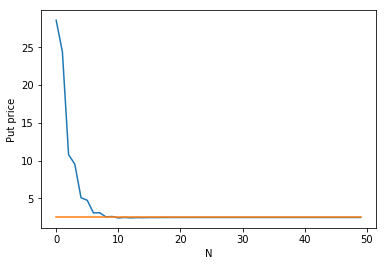

In [23]:
#Plotting the results
plt.plot(COS_put_price)
plt.plot([analytic_put_price]*50)
plt.xlabel("N")
plt.ylabel("Put price")

#Observe the price converges into analytical value pretty quickly with in first 7-8 iterations.

Text(0, 0.5, 'Log absolute error')

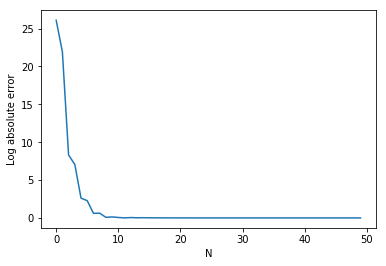

In [24]:
#Plotting the log error
plt.plot(np.absolute(COS_put_price-analytic_put_price))
plt.xlabel("N")
plt.ylabel("Log absolute error")
#Also the error is zero after 7-8 iterations 

In [25]:
#FFT algorithm

def fft(x):
    N = len(x)
    if N == 1:
        return x
    else:
        ek = fft(x[:-1:2])
        ok = fft(x[1::2])
        m = np.array(range(int(N/2)))
        okm = ok * np.exp(-1j*2*np.pi*m/N)
        return np.concatenate((ek+okm, ek-okm))

In [137]:
# FFT Algorithm info
N = 2**10
delta = 0.25
alpha = -1.5 # Alpha must be less than -1 to evaluate FFT Puts

In [134]:
#Characterstic function of St
def log_char(u):
    return np.exp(1j*u*(np.log(S0)+(r-sigma**2/2)*T)-sigma**2*T*u**2/2)

def p_func(v):
    val1 = np.exp(-r*T)*log_char(v-(alpha+1)*1j)
    val2 = alpha**2+alpha-v**2+1j*(2*alpha+1)*v
    return val1/val2

In [135]:
#Variables to vertorize pricing function
n = np.array(range(N))
delta_k = 2*np.pi/(N*delta)
b = delta_k*(N-1)/2

log_strike = np.linspace(-b,b,N)

In [136]:
#Calc Xn, divide first Xn vy 2 and calc FFT of Xn
x = np.exp(1j*b*n*delta)*p_func(n*delta)*(delta)
x[0] = x[0]*0.5
x[-1] = x[-1]*0.5

xhat = fft(x).real
fft_put = np.exp(-alpha*log_strike)*xhat/np.pi


In [138]:
#Analytical solution for vanilla European Put Option
d_1 = (np.log(S0/np.exp(log_strike))+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
d_2 = d_1 - sigma*np.sqrt(T)
analytic_putprice = np.exp(log_strike)*np.exp(-r*(T))*norm.cdf(-d_2) - S0*norm.cdf(-d_1)

#analytic_putprice = analytic_callprice +  K * np.exp(-r * (T)) -S0
#print("analytic_putprice: ",analytic_putprice)

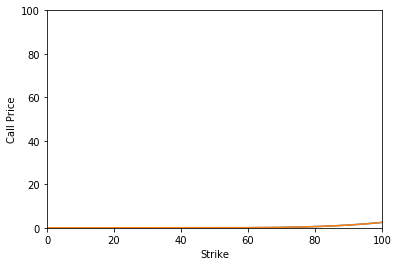

In [139]:
#Plotting the results
plt.plot(np.exp(log_strike), analytic_putprice)
plt.plot(np.exp(log_strike), fft_put)
plt.axis([0,100,0,100])
plt.xlabel("Strike")
plt.ylabel("Call Price")
plt.show()

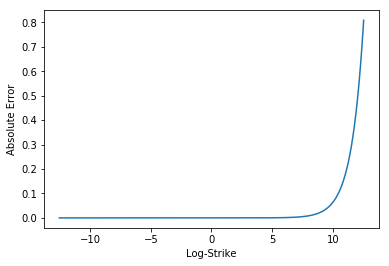

In [140]:
#Plotting Absolute Error
plt.plot(log_strike, np.absolute(fft_put-analytic_putprice)) 
plt.xlabel("Log-Strike")
plt.ylabel("Absolute Error")
plt.show()